In [110]:
import pystan
from pystan import StanModel

import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

from sklearn import cross_validation
from sklearn.metrics import mean_squared_error

import pickle

In [2]:
kilo10000 = pd.read_csv("../data/kilo10000_interpolate.csv")
kilo10001 = pd.read_csv("../data/kilo10001_interpolate.csv")
kilo10002 = pd.read_csv("../data/kilo10002_interpolate.csv")
kilo10003 = pd.read_csv("../data/kilo10003_interpolate.csv")
kilo10004 = pd.read_csv("../data/kilo10004_interpolate.csv")
data = pd.concat((kilo10000["高低左"],kilo10001["高低左"],kilo10002["高低左"],kilo10003["高低左"],kilo10004["高低左"]), axis=1)
data.columns = ["10000","10001","10002","10003","10004"]
data.index = pd.to_datetime(kilo10000["date"])
data.head()

,10000,10001,10002,10003,10004
date,,,,,
2017-04-01,-1.16,-1.17,-1.09,-0.64,0.470
2017-04-02,-0.81,-0.83,-0.71,-0.15,1.010
2017-04-03,-0.99,-0.91,-0.67,-0.02,1.220
2017-04-04,-0.98,-0.81,-0.50,0.18,1.385
2017-04-05,-0.97,-0.71,-0.33,0.38,1.550


In [3]:
data["2017"]

,10000,10001,10002,10003,10004
date,,,,,
2017-04-01,-1.160000,-1.170,-1.090000,-0.640,0.470
2017-04-02,-0.810000,-0.830,-0.710000,-0.150,1.010
2017-04-03,-0.990000,-0.910,-0.670000,-0.020,1.220
2017-04-04,-0.980000,-0.810,-0.500000,0.180,1.385
2017-04-05,-0.970000,-0.710,-0.330000,0.380,1.550
2017-04-06,-1.480000,-1.070,-0.290000,0.950,2.630
2017-04-07,-0.660000,-0.560,-0.460000,-0.100,0.820
2017-04-08,-1.290000,-0.980,-0.560000,0.150,1.300
2017-04-09,-0.980000,-0.820,-0.620000,-0.130,0.870


In [4]:
# 訓練データ, テストデータに分割する
#https://note.nkmk.me/python-pandas-time-series-datetimeindex/
train = data["2017/4/1":"2017/12/31"]
test = data["2018/1/1":]
print ([d.shape for d in [train, test]])

[(275, 5), (90, 5)]


# ローカルレベルモデル

In [85]:
model = """
    data{
        int n; #サンプルサイズ
        vector[n] y;　#観測値
    }
    parameters{
        real muZero;
        vector[n] mu;
        vector[n] y_est;
        real<lower=0> sigmaW;
        real<lower=0> sigmaV;
    }
    model{
    #状態方程式
        mu[1] ~ normal(muZero, sqrt(sigmaW));
        for(i in 2:n){
            mu[i] ~ normal(mu[i-1], sqrt(sigmaW));
        }
    #観測方程式
    for(i in 1:n){
        y[i] ~ normal(mu[i], sqrt(sigmaV));
    }
    #yのサンプルを得たい
    for(i in 1:n){
        y_est[i] ~ normal(mu[i], sqrt(sigmaV));
    }
    }
"""

In [86]:
n = train["10000"].shape[0]
y = train["10000"].values

In [87]:
itr = 2000
warmup = 500
data = {"n":n, "y": y}
chains = 4

fit = pystan.stan(model_code=model, data=data, iter=itr, chains=chains, warmup=warmup)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b82663eae9d242f058cf9723786a766b NOW.


Inference for Stan model: anon_model_b82663eae9d242f058cf9723786a766b.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muZero      7.7e6   1.2e7  2.0e7 -9.7e6 -3.5e6 -2.7e5  1.4e6  6.9e7      3   2.64
mu[0]        -1.2    0.02   0.28  -1.74  -1.39  -1.22  -1.02   -0.6    151   1.04
mu[1]        -1.2    0.02   0.28  -1.73  -1.39  -1.21  -1.03  -0.61    153   1.04
mu[2]        -1.2    0.02   0.27  -1.72  -1.39  -1.22  -1.03  -0.62    143   1.04
mu[3]       -1.21    0.02   0.27  -1.71  -1.39  -1.22  -1.04  -0.64    143   1.04
mu[4]       -1.21    0.02   0.26  -1.71  -1.38  -1.22  -1.04  -0.65    141   1.04
mu[5]       -1.21    0.02   0.26   -1.7  -1.38  -1.22  -1.05  -0.67    144   1.04
mu[6]       -1.21    0.02   0.25   -1.7  -1.39  -1.22  -1.05  -0.69    149   1.04
mu[7]       -1.22    0.02   0.25  -1.69  -1.38  -1.23  -1.06  -0.69    153

In [88]:
la = fit.extract()

In [89]:
pred = la['mu'].mean(axis=0)
mu_lower, mu_upper = np.percentile(la['mu'], q=[2.5, 97.5], axis=0)

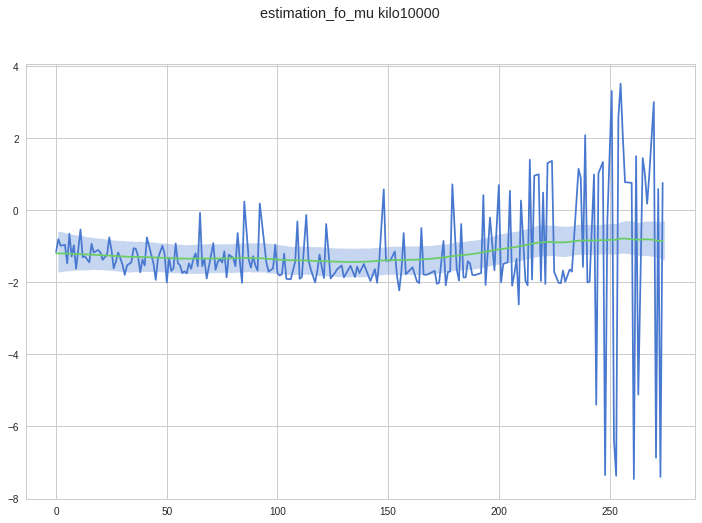

In [90]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.plot(train["10000"].values)
ax1.plot(pred)
plt.fill_between(list(range(1,train["10000"].shape[0]+1)), mu_lower, mu_upper, alpha=0.3)
fig.suptitle("estimation_fo_mu kilo10000")


In [91]:
y_est = la['y_est'].mean(axis=0)
y_est_lower, y_est_upper = np.percentile(la['y_est'], q=[2.5, 97.5], axis=0)

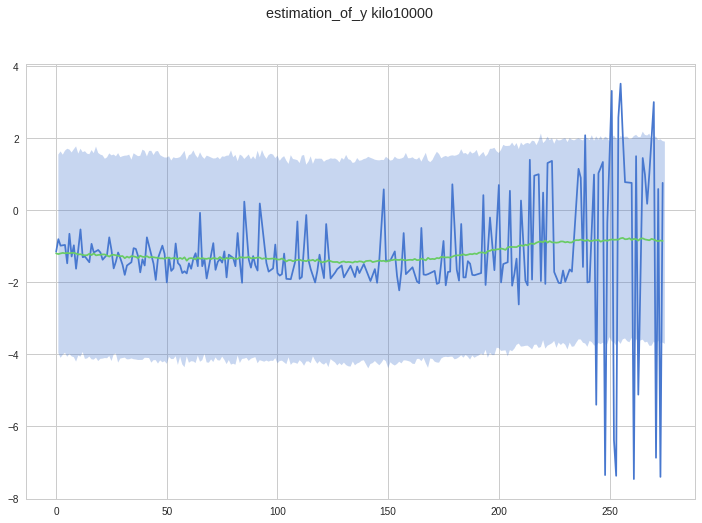

In [94]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.plot(train["10000"].values)
ax1.plot(y_est)
plt.fill_between(list(range(1,train["10000"].shape[0]+1)), y_est_lower, y_est_upper, alpha=0.3)
fig.suptitle("estimation_of_y kilo10000")


In [95]:
#予測値を得るためにはstanモデル自体にパラメータとして書かなければいけない
model = """
    data{
        int n; #トレインサンプルサイズ
        vector[n] y;　#観測値
        int n_pred; #テストサンプルサイズ
    }
    parameters{
        real muZero;
        vector[n] mu;
        real<lower=0> sigmaW;
        real<lower=0> sigmaV;
        vector[n_pred] y_pred;
        vector[n_pred] mu_pred;
        vector[n] y_est;
    }
    model{
    #状態方程式
        mu[1] ~ normal(muZero, sqrt(sigmaW));
        for(i in 2:n){
            mu[i] ~ normal(mu[i-1], sqrt(sigmaW));
        }
        mu_pred[1] ~ normal(mu[n], sqrt(sigmaW));
        for(i in 2:n_pred){
            mu_pred[i] ~ normal(mu_pred[i-1], sqrt(sigmaW));
        }
    #観測方程式
    for(i in 1:n){
        y[i] ~ normal(mu[i], sqrt(sigmaV));
    }
    for(i in 1:n_pred){
        y_pred[i] ~ normal(mu_pred[i], sqrt(sigmaV));
    }
    #yのサンプルを得たい
    for(i in 1:n){
        y_est[i] ~ normal(mu[i], sqrt(sigmaV));
    }

    }
"""

In [96]:
n = train["10000"].shape[0]
y = train["10000"].values
n_pred = test["10000"].shape[0]

In [97]:
itr = 2000
warmup = 500
data = {"n":n, "y": y, "n_pred":n_pred}
chains = 4

fit = pystan.stan(model_code=model, data=data, iter=itr, chains=chains, warmup=warmup)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e8d67343f1db6e83fff360fcd71b962b NOW.


Inference for Stan model: anon_model_e8d67343f1db6e83fff360fcd71b962b.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muZero       -1.22    0.01   0.29   -1.8  -1.41  -1.22  -1.04  -0.65    410   1.01
mu[0]        -1.22    0.01   0.28  -1.78  -1.41  -1.22  -1.04  -0.65    392   1.01
mu[1]        -1.22    0.01   0.28  -1.77   -1.4  -1.23  -1.04  -0.66    380   1.01
mu[2]        -1.22    0.01   0.27  -1.76   -1.4  -1.23  -1.05  -0.69    363   1.01
mu[3]        -1.22    0.01   0.27  -1.75   -1.4  -1.23  -1.05  -0.69    355   1.01
mu[4]        -1.23    0.01   0.26  -1.73  -1.39  -1.23  -1.06  -0.71    352   1.01
mu[5]        -1.23    0.01   0.26  -1.75   -1.4  -1.23  -1.06  -0.72    348   1.01
mu[6]        -1.23    0.01   0.25  -1.74   -1.4  -1.23  -1.06  -0.73    344   1.01
mu[7]        -1.23    0.01   0.25  -1.73   -1.4  -1.23  -1.07  -0

In [112]:
model_name = "local_level"
with open(model_name + '.pkl', 'wb') as f:
    pickle.dump(fit, f)
fit = pickle.load(open(model_name + '.pkl', 'rb'))

/home/watanabe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  app.launch_new_instance()


In [113]:
la = fit.extract()

In [114]:
mu = la['mu'].mean(axis=0)
mu_lower, mu_upper = np.percentile(la['mu'], q=[2.5, 97.5], axis=0)
mu_pred = la['mu_pred'].mean(axis=0)
mu_pred_lower, mu_pred_upper = np.percentile(la['mu_pred'], q=[2.5, 97.5], axis=0)
y_est = la['y_est'].mean(axis=0)
y_est_lower, y_est_upper = np.percentile(la['y_est'], q=[2.5, 97.5], axis=0)
y_pred = la['y_pred'].mean(axis=0)
y_pred_lower, y_pred_upper = np.percentile(la['y_pred'], q=[2.5, 97.5], axis=0)

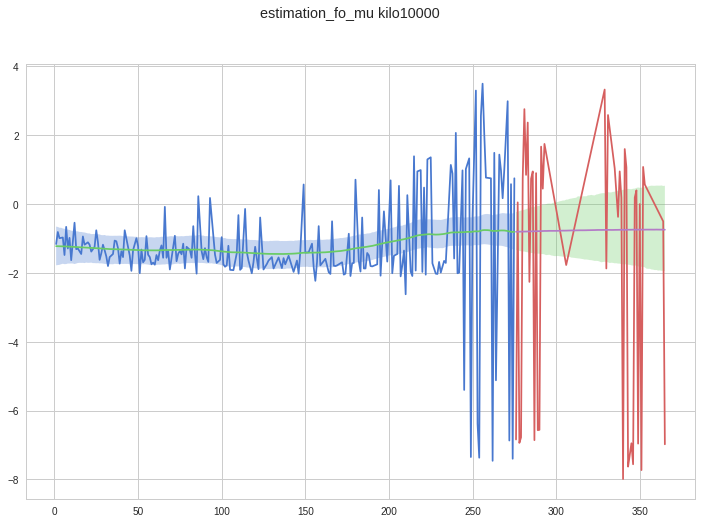

In [115]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.plot(list(range(1,train["10000"].shape[0]+1)),train["10000"].values)
ax1.plot(list(range(1,train["10000"].shape[0]+1)),mu)
plt.fill_between(list(range(1,train["10000"].shape[0]+1)), mu_lower, mu_upper, alpha=0.3)

ax1.plot(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)), test["10000"].values)
ax1.plot(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)),mu_pred)
plt.fill_between(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)), mu_pred_lower, mu_pred_upper, alpha=0.3)

fig.suptitle("estimation_fo_mu kilo10000")


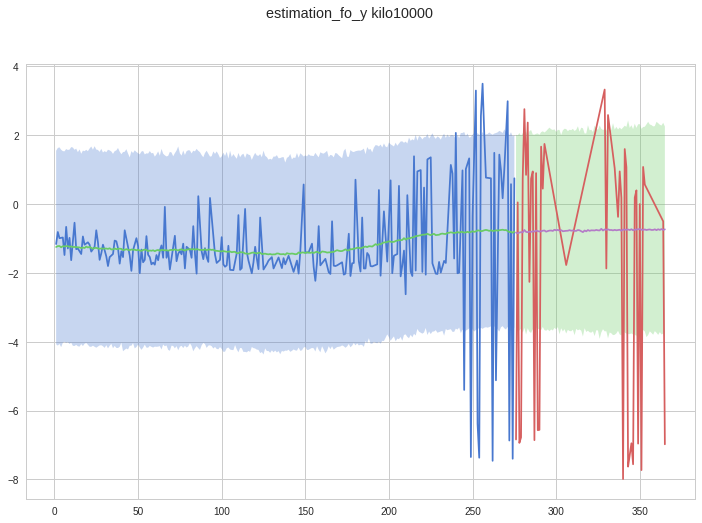

In [105]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.plot(list(range(1,train["10000"].shape[0]+1)),train["10000"].values)
ax1.plot(list(range(1,train["10000"].shape[0]+1)),y_est)
plt.fill_between(list(range(1,train["10000"].shape[0]+1)), y_est_lower, y_est_upper, alpha=0.3)

ax1.plot(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)), test["10000"].values)
ax1.plot(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)),y_pred)
plt.fill_between(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)), y_pred_lower, y_pred_upper, alpha=0.3)

fig.suptitle("estimation_fo_y kilo10000")

In [106]:
#rmse
rmse = np.sqrt(mean_squared_error(test["10000"], mu_pred))
rmse

3.009394502987468

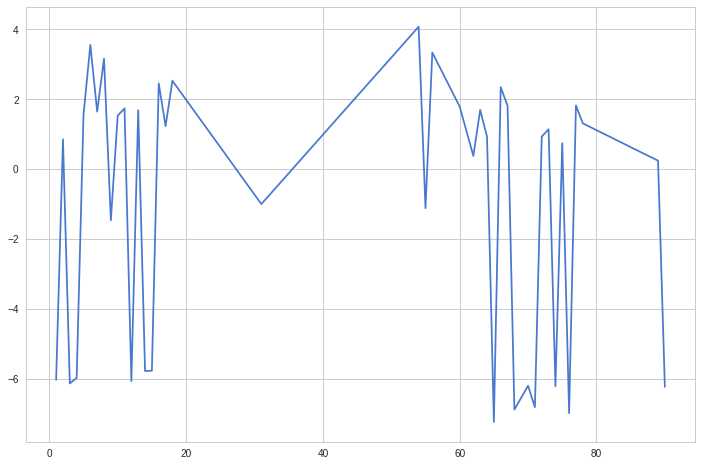

In [107]:
#残差プロット
res = test["10000"] - mu_pred
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.plot(list(range(1,test["10000"].shape[0]+1)),res)

# ローカルトレンドモデル

In [47]:
model = """
    data{
        int n; #サンプルサイズ
        vector[n] y;　#観測値
    }
    parameters{
        real muZero; #レベル初期値
        real trendZero; #トレンド初期値
        vector[n] mu;
        vector[n] trend;
        real<lower=0> sigmaW_mu; # レベルの分散
        real<lower=0> sigmaW_tr; # トレンドの分散
        real<lower=0> sigmaV; #観測雑音
    }
    model{
    #状態方程式
        mu[1] ~ normal(muZero, sqrt(sigmaW_mu));
        trend[1] ~ normal(trendZero, sqrt(sigmaW_tr));
        for(i in 2:n){
            mu[i] ~ normal(mu[i-1] + trend[i-1], sqrt(sigmaW_mu));
            trend[i] ~ normal(trend[i-1], sqrt(sigmaW_tr));
        }
    #観測方程式
    for(i in 1:n){
        y[i] ~ normal(mu[i], sqrt(sigmaV));
    }
    }
    
"""

In [48]:
n = train["10000"].shape[0]
y = train["10000"].values

In [49]:
itr = 2000
warmup = 500
data = {"n":n, "y": y}
chains = 4

fit = pystan.stan(model_code=model, data=data, iter=itr, chains=chains, warmup=warmup)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2f9ece9d12f33f331736b75f22153e3 NOW.


Inference for Stan model: anon_model_e2f9ece9d12f33f331736b75f22153e3.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muZero      -1.12  7.8e-3   0.39  -1.86  -1.38  -1.13  -0.87  -0.33   2493    1.0
trendZero -5.1e-3  3.0e-4   0.02  -0.05  -0.02-4.2e-3 5.4e-3   0.03   4001    1.0
mu[0]       -1.12  7.9e-3   0.39  -1.84  -1.38  -1.13  -0.86  -0.34   2367    1.0
mu[1]       -1.13  7.8e-3   0.37  -1.82  -1.38  -1.13  -0.88  -0.37   2260    1.0
mu[2]       -1.13  7.6e-3   0.36   -1.8  -1.38  -1.13  -0.89   -0.4   2235    1.0
mu[3]       -1.14  7.2e-3   0.34  -1.78  -1.37  -1.14  -0.91  -0.44   2258    1.0
mu[4]       -1.14  6.7e-3   0.33  -1.77  -1.37  -1.14  -0.92  -0.46   2431    1.0
mu[5]       -1.15  6.7e-3   0.32  -1.76  -1.37  -1.15  -0.94  -0.49   2304    1.0
mu[6]       -1.15  6.3e-3   0.31  -1.75  -1.37  -1.15  -0.95  -0.52   2518

In [51]:
la = fit.extract()

In [54]:
mu = la['mu'].mean(axis=0)
mu_lower, mu_upper = np.percentile(la['mu'], q=[2.5, 97.5], axis=0)

trend = la['trend'].mean(axis=0)
trend_lower, trend_upper = np.percentile(la['trend'], q=[2.5, 97.5], axis=0)

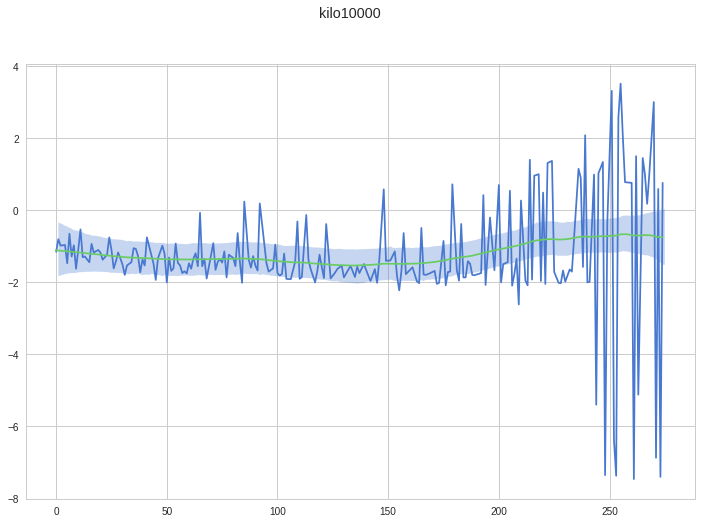

In [55]:
y = mu + trend
y_lower = mu_lower + trend_lower
y_upper = mu_upper + trend_upper

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.plot(train["10000"].values)
ax1.plot(y)
ax1.fill_between(list(range(1,train["10000"].shape[0]+1)), y_lower, y_upper, alpha=0.3)
fig.suptitle("kilo10000")

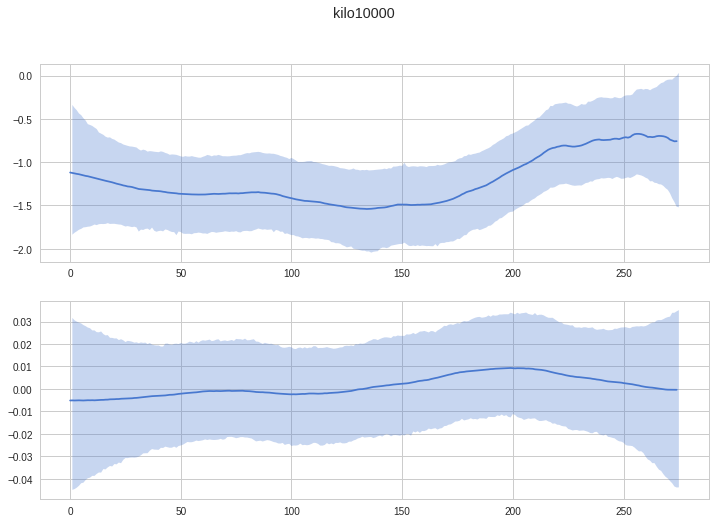

In [61]:

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1.plot(mu)
ax1.fill_between(list(range(1,train["10000"].shape[0]+1)), mu_lower, mu_upper, alpha=0.3)


ax2 = fig.add_subplot(212)
ax2.plot(trend)
ax2.fill_between(list(range(1,train["10000"].shape[0]+1)), trend_lower, trend_upper, alpha=0.3)


fig.suptitle("kilo10000")

In [76]:
model = """
    data{
        int n; #トレインサンプルサイズ
        vector[n] y;　#観測値
        int n_pred; #テストサンプルサイズ
    }
    parameters{
        real muZero; #レベル初期値
        real trendZero; #トレンド初期値
        vector[n] mu;
        vector[n] trend;
        vector[n_pred] mu_pred;
        vector[n_pred] trend_pred;
        vector[n_pred] y_pred;
        real<lower=0> sigmaW_mu; # レベルの分散
        real<lower=0> sigmaW_tr; # トレンドの分散
        real<lower=0> sigmaV; #観測雑音
    }
    model{
    #状態方程式
        mu[1] ~ normal(muZero + trendZero, sqrt(sigmaW_mu));
        trend[1] ~ normal(trendZero, sqrt(sigmaW_tr));
        for(i in 2:n){
            mu[i] ~ normal(mu[i-1] + trend[i-1], sqrt(sigmaW_mu));
            trend[i] ~ normal(trend[i-1], sqrt(sigmaW_tr));
        }
        mu_pred[1] ~ normal(mu[n] + trend[n], sqrt(sigmaW_mu));
        trend_pred[1] ~ normal(trend[n], sqrt(sigmaW_tr));
        for(i in 2:n_pred){
            mu_pred[i] ~ normal(mu_pred[i-1] + trend_pred[i-1], sqrt(sigmaW_mu));
            trend_pred[i] ~ normal(trend_pred[i-1], sqrt(sigmaW_tr));
        }
        
    #観測方程式
    for(i in 1:n){
        y[i] ~ normal(mu[i], sqrt(sigmaV));
    }
    for(i in 1:n_pred){
        y_pred[i] ~ normal(mu_pred[i], sqrt(sigmaV));
    }
    }
    
"""

In [77]:
n = train["10000"].shape[0]
y = train["10000"].values
n_pred = test["10000"].shape[0]

In [78]:
itr = 1500
warmup = 500
data = {"n":n, "y": y, "n_pred":n_pred}
chains = 4

%time fit = pystan.stan(model_code=model, data=data, iter=itr, chains=chains, warmup=warmup)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_86ea4672965e8df1c1723e4ae3606e93 NOW.


CPU times: user 1.71 s, sys: 346 ms, total: 2.05 s
Wall time: 10min 33s


Inference for Stan model: anon_model_86ea4672965e8df1c1723e4ae3606e93.
4 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muZero          -1.12    0.02   0.39   -1.9  -1.39  -1.13  -0.87  -0.32    591    1.0
trendZero     -4.5e-3  5.8e-4   0.02  -0.04  -0.01-3.7e-3 5.1e-3   0.02    761    1.0
mu[0]           -1.13    0.02   0.38  -1.89  -1.38  -1.13  -0.88  -0.35    566    1.0
mu[1]           -1.14    0.02   0.37  -1.86  -1.39  -1.15   -0.9  -0.38    526    1.0
mu[2]           -1.14    0.02   0.36  -1.86  -1.39  -1.15  -0.91  -0.43    521   1.01
mu[3]           -1.15    0.02   0.35  -1.86  -1.39  -1.15  -0.93  -0.46    512    1.0
mu[4]           -1.16    0.01   0.33  -1.83  -1.38  -1.16  -0.94  -0.47    501    1.0
mu[5]           -1.16    0.01   0.32  -1.82  -1.38  -1.17  -0.95  -0.51    510    1.0
mu[6]           -1.17    0.01   0.31  

In [79]:
la = fit.extract()

In [82]:
mu = la['mu'].mean(axis=0)
mu_lower, mu_upper = np.percentile(la['mu'], q=[2.5, 97.5], axis=0)
mu_pred = la['mu_pred'].mean(axis=0)
mu_pred_lower, mu_pred_upper = np.percentile(la['mu_pred'], q=[2.5, 97.5], axis=0)

trend = la['trend'].mean(axis=0)
trend_lower, trend_upper = np.percentile(la['trend'], q=[2.5, 97.5], axis=0)
trend_pred = la['trend_pred'].mean(axis=0)
trend_pred_lower, trend_pred_upper = np.percentile(la['trend_pred'], q=[2.5, 97.5], axis=0)


y_pred = la['y_pred'].mean(axis=0)
y_pred_lower, y_pred_upper = np.percentile(la['y_pred'], q=[2.5, 97.5], axis=0)

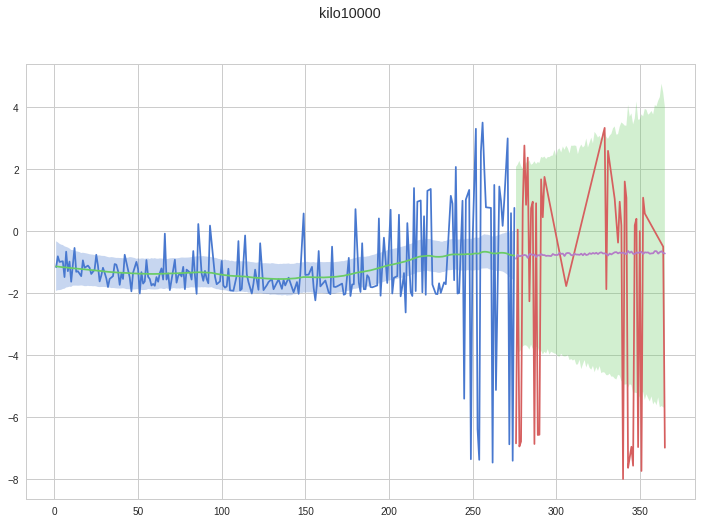

In [84]:
y = mu + trend
y_lower = mu_lower + trend_lower
y_upper = mu_upper + trend_upper

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.plot(list(range(1,train["10000"].shape[0]+1)),train["10000"].values)
ax1.plot(list(range(1,train["10000"].shape[0]+1)),y)
ax1.fill_between(list(range(1,train["10000"].shape[0]+1)), y_lower, y_upper, alpha=0.3)

ax1.plot(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)), test["10000"].values)
ax1.plot(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)), y_pred)
ax1.fill_between(list(range(train["10000"].shape[0]+1,train["10000"].shape[0]+test["10000"].shape[0]+1)), y_pred_lower, y_pred_upper, alpha=0.3)



fig.suptitle("kilo10000")